# **Respiratory Rate Estimation**
### Project by Laura Settimo, Caterina Gasbarrini, Francesco Zanirato e Alessandro Canova

With modern technologies it's possible to create devices able to detect the Heart Rate and the Respiratory Rate combining data from an accelerometers and a gyroscopes. Two of these technique are Seismocardiography (SCG) and Ballistocardiography (BSG). They both can use a combination of the two sensors but BSG, differently from SCG, doesn't require a direct contact with the body, so the sensors can be placed in different locations.

In this project we will analyze data captured by a device called IMU (Inertial Measurement Unit) that measures accelerometer and gyroscope data, in addition with other measurements like magnitude and spatial orientation of the device.

The first dataset which we analyze is about SCG and it was captured by placing the device at the center of the sternum. During the measurement the subject was lying supine.
<br>

The second dataset we selected was captured placing the sensor on a bed stave, under the mattress at the level of the chest. This means that the measurement is about BSG.

The picutre below show where the sensors for SCG is placed. 

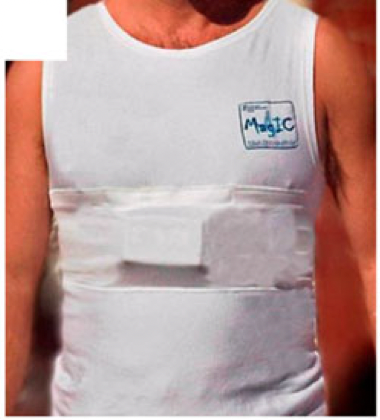

In [1]:
from IPython.display import Image
Image('SCG picture.png')

The second image shows a possible location of the sensors in BCG.

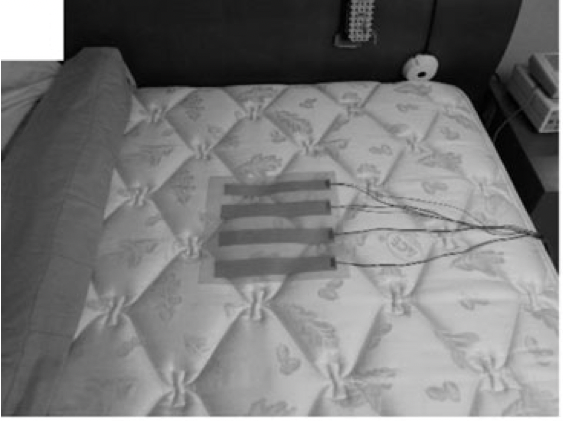

In [2]:
Image('BCG picture.png')

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import numpy.linalg as la
from scipy import fftpack
from scipy.signal import correlate
from scipy.signal import butter, filtfilt, find_peaks
from scipy import optimize 
from scipy.optimize import curve_fit

## 1. Data preparation

Before starting, we created a set of functions and some constant variables useful for the project

In [4]:
#calculation of std 
def std_calc(arr):
    center = int(arr.shape[0]/2)
    std_down = [np.std(arr[(center - ind):center]) for ind in range(1, center, 1)]
    std_up = [np.std(arr[center:(center + ind)]) for ind in range(1, center, 1)]

    return np.concatenate((std_down[::-1], std_up))

def pca_calc(data):
    cov = np.cov(data.T)
    val, vec = la.eig(cov)
    return val*100/val.sum()

def calculate_norm(c):
    c =np.array([c[column].tolist() for column in c.columns])
    return np.array(np.sqrt(c[0]**2 + c[1]**2 + c[2]**2))
     
color1 = '#3a3042'
color2 = '#db9d47'
color3 = '#ff784f'


### 1.1 Load file and select the columns

We read the file in a Pandas dataframe and we show the data and its statistical description using the integrated Pandas function.

As we know from the assignment, we have 16 columns. Specifically:
* Log Freq stands for the acquisition in Hz.
* AccX, AccY, AccZ are the measured magnitude of linear acceleration along each axis.
* GyroX, GyroY, GyroZ are the measured magnitude of angular velocity along each axis.
* MagnX, MagnY, MagnZ are the measured magnitude of magnetic field along each axis.
* qw, qi, qj, qk are the quaternion components, representing the spatial orientation of the Muse system.




In [5]:
file = pd.read_csv('center_sternum.txt', delimiter='\t')
df = pd.DataFrame(file)

#show the dataframe
display(df)

#description of data
df.describe()

,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
0,5,200,1576222772,947.086,435.662,70.638,-6.824428,-14.244280,1.404580,-454,-490,-178,0.792622,0.254952,-0.553850,-0.000031
1,5,200,1576222772,969.168,387.777,88.877,6.183206,-12.290080,-7.969466,-454,-490,-177,0.736461,0.275124,-0.617969,0.006806
2,5,200,1576222772,989.603,380.335,78.751,11.709920,-4.961832,-7.450382,-454,-490,-177,0.729465,0.275246,-0.626118,0.009827
3,5,200,1576222772,954.894,418.033,88.328,17.877860,2.519084,-5.984733,-454,-492,-176,0.723413,0.277200,-0.632221,0.011383
4,5,200,1576222772,972.096,427.732,99.857,25.221370,5.404580,4.015267,-454,-492,-176,0.721948,0.280007,-0.632679,0.010193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16501,5,200,1576222847,958.493,291.092,-54.290,1.664122,2.305344,-0.671756,-494,-449,-126,0.650810,0.379162,-0.636402,0.166356
16502,5,200,1576222847,954.650,288.042,-49.654,1.480916,2.488550,-0.702290,-494,-450,-125,0.650239,0.379803,-0.636708,0.165960
16503,5,200,1576222847,967.338,290.482,-63.867,1.114504,3.374046,-0.900763,-494,-450,-125,0.649365,0.380627,-0.637227,0.165502
16504,5,200,1576222847,965.630,300.852,-56.242,0.702290,3.664122,-1.587786,-495,-448,-124,0.648973,0.381329,-0.637348,0.164953


,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
count,16506.0,16506.0,1.650600e+04,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000
mean,5.0,200.0,1.576223e+09,35.603752,121.754422,-897.001465,-1.885665,3.636535,-0.818354,-231.327881,-432.637405,397.903005,0.063803,0.490530,-0.764329,-0.039947
std,0.0,0.0,2.189258e+01,232.624330,62.077114,215.230574,13.223364,17.399954,10.595643,67.200320,16.526077,123.871453,0.144073,0.197328,0.326346,0.057694
min,5.0,200.0,1.576223e+09,-722.118000,-387.838000,-1731.973000,-359.496200,-213.557300,-126.351100,-511.000000,-559.000000,-178.000000,0.004428,-0.622059,-0.892911,-0.096347
25%,5.0,200.0,1.576223e+09,-35.258000,111.020000,-958.310000,-2.839695,3.206107,-1.175573,-213.000000,-434.000000,427.000000,0.021518,0.493858,-0.859676,-0.060732
50%,5.0,200.0,1.576223e+09,-29.585000,115.900000,-948.733000,-2.137405,3.664122,-0.854962,-212.000000,-432.000000,429.000000,0.024636,0.529649,-0.836619,-0.059511
75%,5.0,200.0,1.576223e+09,-22.692000,120.475000,-937.692000,-1.206107,4.213740,-0.549618,-211.000000,-431.000000,433.000000,0.027304,0.564768,-0.813227,-0.057619
max,5.0,200.0,1.576223e+09,1228.601000,1004.609000,3087.000000,381.160300,349.816800,187.603100,-130.000000,-289.000000,481.000000,0.792622,0.624806,0.921293,0.251900


We can see that the frequency of the acquisition rate is constant, therefore the time distance between two samples remains unchanged during the whole measurement.
We create an array starting from 0 containing the time information. This new vector will replace the 'Timestamp' column which contains meaningless data for our purpose. 

In [6]:
frequency = df['Log Freq'].unique()[0] 
count = df.shape[0]


time_arr = np.arange(0,(count/frequency),(1/frequency))

After consulting pubblications [1] about SCG and BCG we understood that these two techniques are based only on acceleration and angular velocity data; thus we decided to drop the columns of the other measurements. <br>
We also add the column containing the new time reference.

In [7]:
columns_drop = [
    'Timestamp',
    'qw',
    'qi',
    'qk',
    'qj',
    'Log Freq',
    'Log Mode',
    'MagnX',
    'MagnY',
    'MagnZ'
]
partial_data = df.drop(columns_drop,axis=1)
partial_data.insert(0,'Time',time_arr)
display(partial_data)

,Time,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
0,0.000,947.086,435.662,70.638,-6.824428,-14.244280,1.404580
1,0.005,969.168,387.777,88.877,6.183206,-12.290080,-7.969466
2,0.010,989.603,380.335,78.751,11.709920,-4.961832,-7.450382
3,0.015,954.894,418.033,88.328,17.877860,2.519084,-5.984733
4,0.020,972.096,427.732,99.857,25.221370,5.404580,4.015267
...,...,...,...,...,...,...,...
16501,82.505,958.493,291.092,-54.290,1.664122,2.305344,-0.671756
16502,82.510,954.650,288.042,-49.654,1.480916,2.488550,-0.702290
16503,82.515,967.338,290.482,-63.867,1.114504,3.374046,-0.900763
16504,82.520,965.630,300.852,-56.242,0.702290,3.664122,-1.587786


As we know from the file 'config_1.txt' the measurements of the accelerometer has to be calibrated, removing the specified offsets on the acceleration for the three axis.

In [8]:
offsets = [-3.929942,-13.74679,60.67546]

partial_data['AccX'] -= offsets[0]
partial_data['AccY'] -= offsets[1]
partial_data['AccZ'] -= offsets[2]

display(partial_data)
partial_data.describe()

,Time,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
0,0.000,951.015942,449.40879,9.96254,-6.824428,-14.244280,1.404580
1,0.005,973.097942,401.52379,28.20154,6.183206,-12.290080,-7.969466
2,0.010,993.532942,394.08179,18.07554,11.709920,-4.961832,-7.450382
3,0.015,958.823942,431.77979,27.65254,17.877860,2.519084,-5.984733
4,0.020,976.025942,441.47879,39.18154,25.221370,5.404580,4.015267
...,...,...,...,...,...,...,...
16501,82.505,962.422942,304.83879,-114.96546,1.664122,2.305344,-0.671756
16502,82.510,958.579942,301.78879,-110.32946,1.480916,2.488550,-0.702290
16503,82.515,971.267942,304.22879,-124.54246,1.114504,3.374046,-0.900763
16504,82.520,969.559942,314.59879,-116.91746,0.702290,3.664122,-1.587786


,Time,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
count,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000
mean,41.262500,39.533694,135.501212,-957.676925,-1.885665,3.636535,-0.818354
std,23.825081,232.624330,62.077114,215.230574,13.223364,17.399954,10.595643
min,0.000000,-718.188058,-374.091210,-1792.648460,-359.496200,-213.557300,-126.351100
25%,20.631250,-31.328058,124.766790,-1018.985460,-2.839695,3.206107,-1.175573
50%,41.262500,-25.655058,129.646790,-1009.408460,-2.137405,3.664122,-0.854962
75%,61.893750,-18.762058,134.221790,-998.367460,-1.206107,4.213740,-0.549618
max,82.525000,1232.530942,1018.355790,3026.324540,381.160300,349.816800,187.603100


### 1.2 Plot selected data and choose a proper time window

We create two plots for the measurements of the accelerometer and the gyroscope data, as a function of time. 


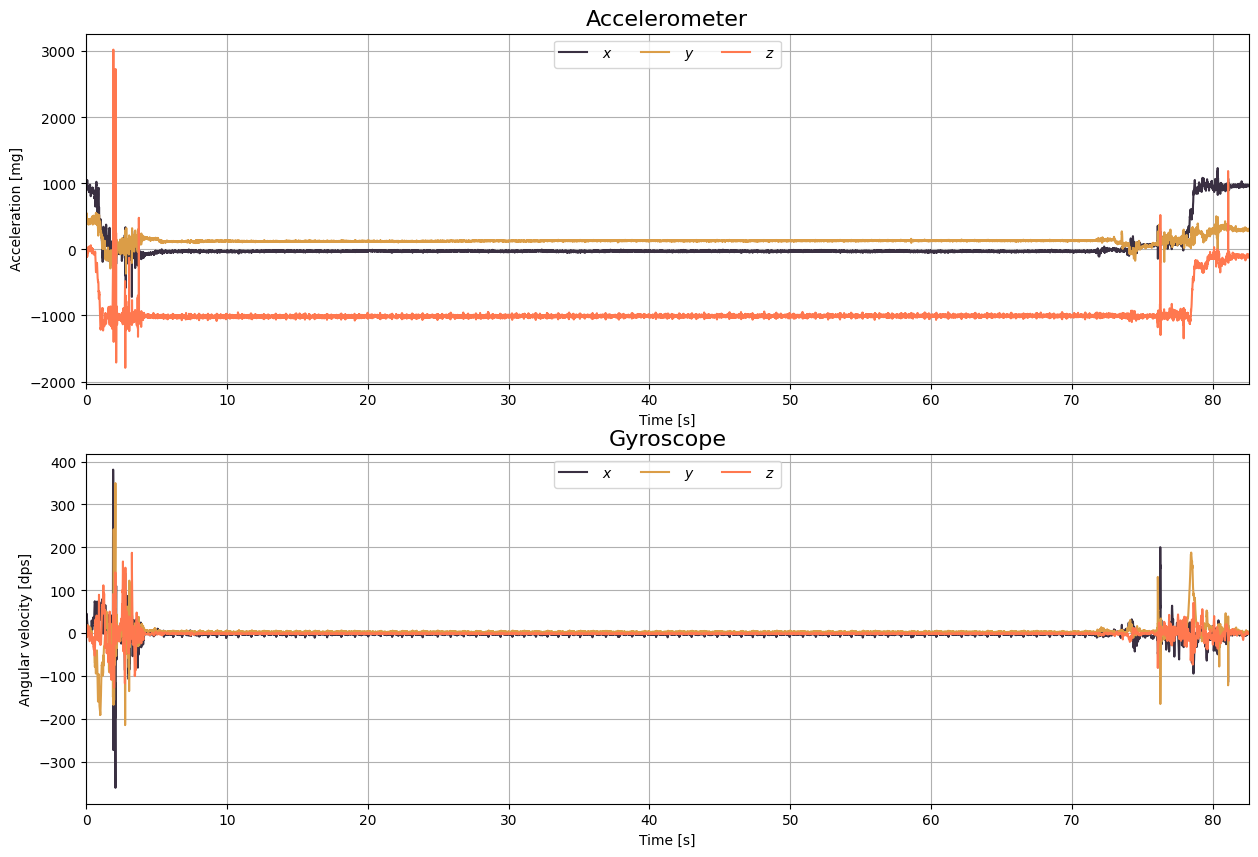

In [9]:
fig1, ax1 = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 10))

ax1[0].plot(partial_data['Time'], partial_data['AccX'], '-', label=' $x$ ', color = color1)
ax1[0].plot(partial_data['Time'], partial_data['AccY'], '-', label=' $y$ ', color = color2)
ax1[0].plot(partial_data['Time'], partial_data['AccZ'], '-', label=' $z$ ', color = color3)
ax1[0].set_xlim(0, partial_data['Time'].max())
ax1[0].set_xlabel('Time [s]')
ax1[0].set_ylabel('Acceleration [mg]')
ax1[0].legend(loc='upper center', ncol = 3)
ax1[0].set_title('Accelerometer',fontsize=16)
ax1[0].grid()

ax1[1].plot(partial_data['Time'], partial_data['GyroX'], '-', label = ' $x$ ', color = color1)
ax1[1].plot(partial_data['Time'], partial_data['GyroY'], '-', label = ' $y$ ', color = color2)
ax1[1].plot(partial_data['Time'], partial_data['GyroZ'], '-', label = ' $z$ ', color = color3)
ax1[1].set_xlim(0, partial_data['Time'].max())
ax1[1].set_title('Gyroscope', fontsize = 16)
ax1[1].set_xlabel('Time [s]')
ax1[1].set_ylabel('Angular velocity [dps]')
ax1[1].legend(loc = 'upper center', ncol = 3)
ax1[1].grid()

From the graphical representation we can see that at the beginning and at the end of the data there are big oscillations.
This behaviour could be caused by the movements of the subject.
In fact, if the big oscillations were caused by respiration, the central portion of the signal should be interpreted as no-respiration, which is quite unusual. <br>
For this reason we decided to remove these portions of data and to keep only the data that goes from 10 seconds to 70 seconds (from the 2000th to the 14000th measure).

In [10]:
center_idx = int(partial_data.shape[0]/2)
down_idx = 2000
up_idx = 14000
print(f'The percentage of data to keep is {(up_idx-down_idx)/partial_data.shape[0]*100:.2f}% ' )

down_limit = (partial_data['Time'])[down_idx]
up_limit = (partial_data['Time'])[up_idx]

The percentage of data to keep is 72.70% 


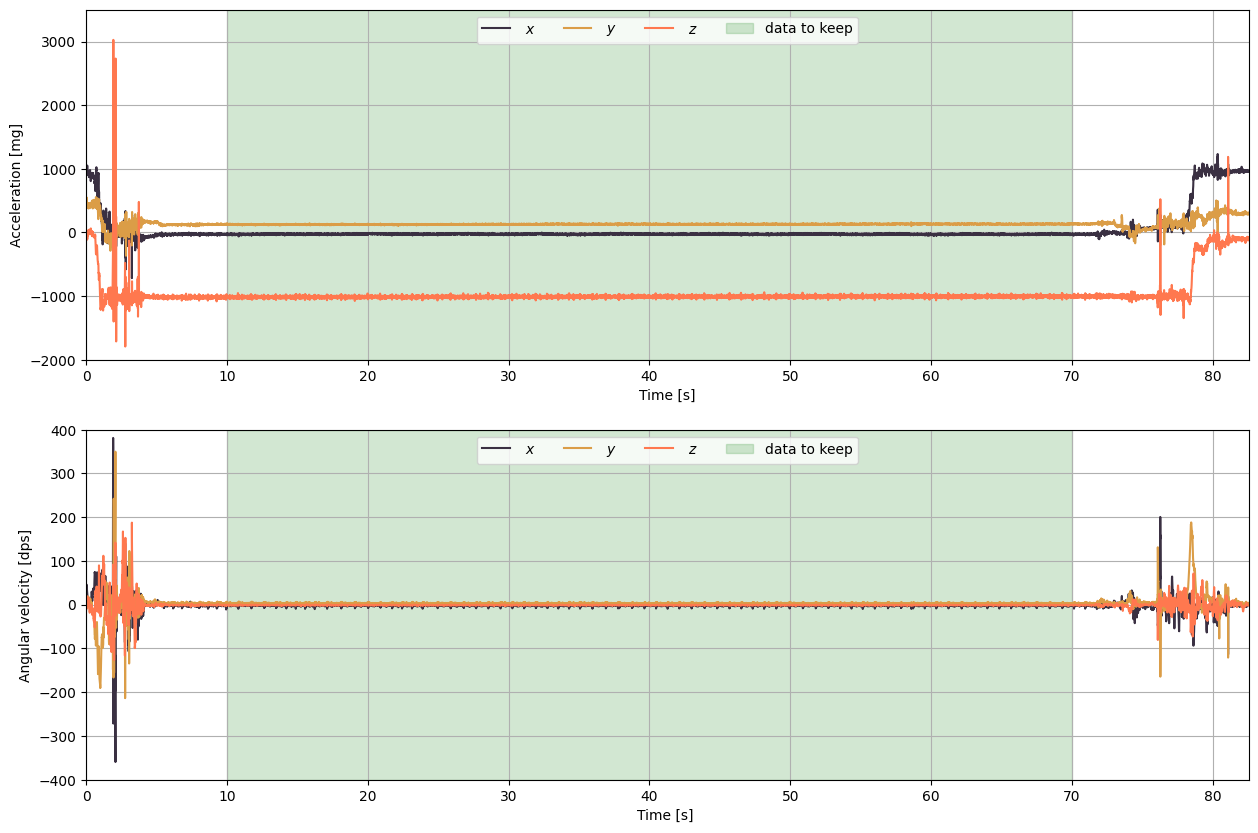

In [11]:
fig3, ax3 = plt.subplots(nrows = 2, figsize = (15, 10))

ax3[0].plot(partial_data['Time'],partial_data['AccX'], '-', label = ' $x$ ', color = '#3a3042')
ax3[0].plot(partial_data['Time'],partial_data['AccY'], '-', label = ' $y$ ', color = '#db9d47')
ax3[0].plot(partial_data['Time'],partial_data['AccZ'], '-', label = ' $z$ ', color = '#ff784f')
ax3[0].fill_betweenx(y = [-2000, 3500], x1 = down_limit, x2 = up_limit,
                     color = 'forestgreen', alpha = 0.2, label = 'data to keep')
ax3[0].set_xlim(min(partial_data['Time']), max(partial_data['Time']))
ax3[0].set_ylim(-2000, 3500)
ax3[0].set_xlabel('Time [s]')
ax3[0].set_ylabel('Acceleration [mg]')
ax3[0].legend(loc = 'upper center', ncol = 4)
ax3[0].grid()

ax3[1].plot(partial_data['Time'], partial_data['GyroX'], '-' , label = ' $x$ ' , color='#3a3042' )
ax3[1].plot(partial_data['Time'], partial_data['GyroY'], '-' , label = ' $y$ ' , color='#db9d47' )
ax3[1].plot(partial_data['Time'], partial_data['GyroZ'], '-' , label = ' $z$ ' , color='#ff784f' )
ax3[1].fill_betweenx(y = [-400, 400], x1 = down_limit, x2 = up_limit,
                     color = 'forestgreen', alpha = 0.2, label = 'data to keep')
ax3[1].set_xlim(min(partial_data['Time']), max(partial_data['Time']))
ax3[1].set_ylim(-400, 400)
ax3[1].set_xlabel('Time [s] ')
ax3[1].set_ylabel('Angular velocity [dps]')
ax3[1].legend(loc = 'upper center', ncol = 4)
ax3[1].grid()



The data at the beginning and the end is than cut and the indexes are adjusted.

In [12]:
final_data = partial_data.copy()
final_data = final_data[final_data['Time'] >= down_limit]
final_data = final_data[final_data['Time'] <= up_limit]
final_data.set_index(np.arange(0,len(final_data)), inplace=True)
display(final_data)

times = np.array(final_data['Time'])


,Time,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
0,10.000,-28.705058,126.65779,-1014.47146,1.755725,5.022901,-0.809160
1,10.005,-15.224058,126.10879,-1032.28346,1.557252,4.198473,-1.083969
2,10.010,-23.520058,124.33979,-1004.95546,0.931298,4.320611,-1.099237
3,10.015,-17.847058,127.69479,-1001.47846,0.946565,4.137404,-1.267176
4,10.020,-28.461058,131.96479,-985.06946,1.022901,4.702290,-0.992366
...,...,...,...,...,...,...,...
11996,69.980,-26.936058,132.51379,-1001.78346,-3.175573,3.358779,-0.778626
11997,69.985,-28.888058,132.02579,-1002.82046,-2.992366,3.679389,-0.549618
11998,69.990,-18.762058,127.45079,-1008.85946,-3.022901,3.786260,-0.564886
11999,69.995,-34.744058,133.48979,-997.81846,-2.854962,3.419847,-0.885496


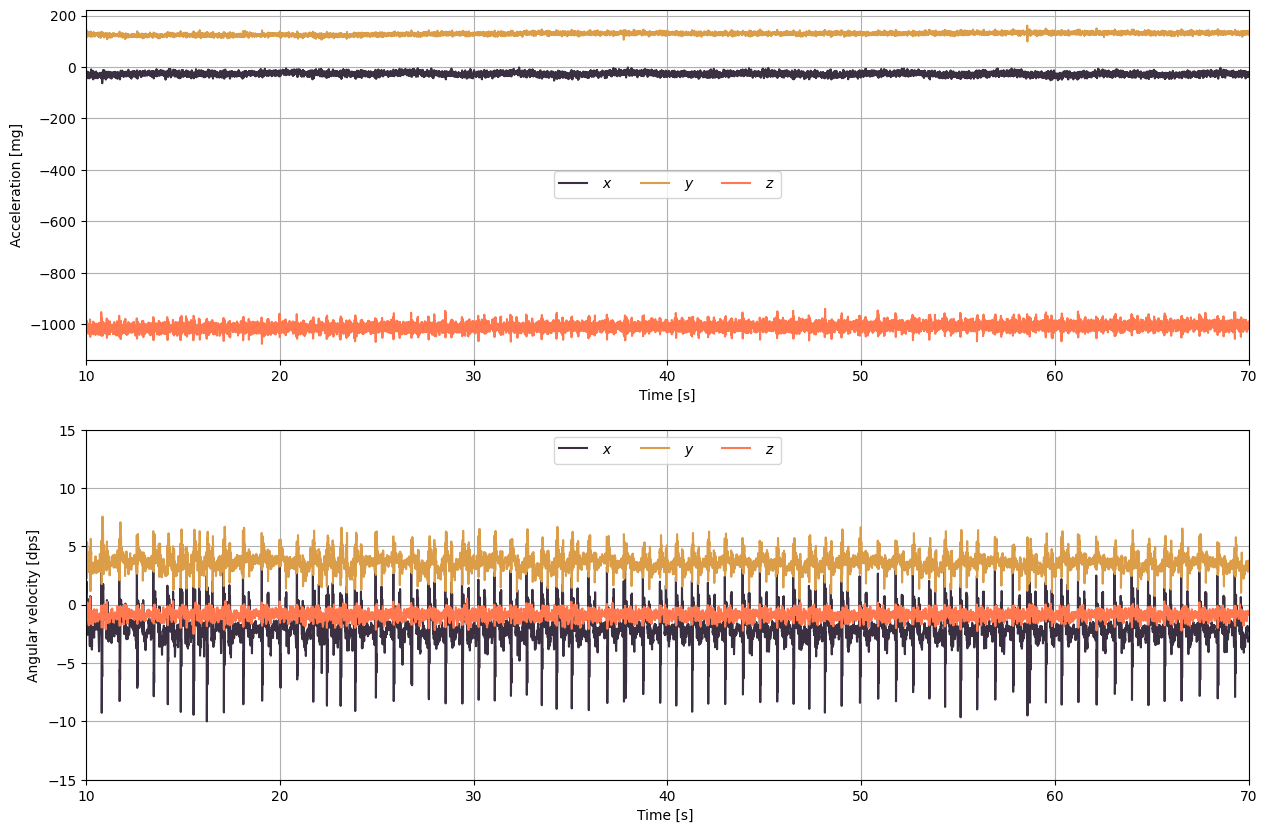

In [13]:
fig3, ax3 = plt.subplots(nrows = 2, figsize = (15, 10))

ax3[0].plot(final_data['Time'],final_data['AccX'], '-', label = ' $x$ ', color = '#3a3042')
ax3[0].plot(final_data['Time'],final_data['AccY'], '-', label = ' $y$ ', color = '#db9d47')
ax3[0].plot(final_data['Time'],final_data['AccZ'], '-', label = ' $z$ ', color = '#ff784f')
ax3[0].set_xlim(min(final_data['Time']), max(final_data['Time']))
#ax3[0].set_xlim(40,20)
#ax3[0].set_ylim(-50,0)

ax3[0].set_xlabel('Time [s]')
ax3[0].set_ylabel('Acceleration [mg]')
ax3[0].legend(loc = 'center', ncol = 4)
ax3[0].grid()

ax3[1].plot(final_data['Time'], final_data['GyroX'], '-' , label = ' $x$ ' , color='#3a3042' )
ax3[1].plot(final_data['Time'], final_data['GyroY'], '-' , label = ' $y$ ' , color='#db9d47' )
ax3[1].plot(final_data['Time'], final_data['GyroZ'], '-' , label = ' $z$ ' , color='#ff784f' )

ax3[1].set_xlim(min(final_data['Time']), max(final_data['Time']))
ax3[1].set_ylim(-15, 15)
ax3[1].set_xlabel('Time [s] ')
ax3[1].set_ylabel('Angular velocity [dps]')
ax3[1].legend(loc = 'upper center', ncol = 4)
ax3[1].grid()

### 1.3 Consider particular axis or combination of them

In order to check if it is possible to neglect some components of the dataset we decided to perform a PCA.
To compute the PCA decomposition we use the 'pca_calc()' function defined before.

In [14]:
data_acc = final_data[['AccX','AccY','AccZ']]

data_gyro = final_data[['GyroX','GyroY','GyroZ']]

1.3.1 PCA on accelerometer data

In [15]:
#PCA with eigen decomposition
acc_pca = pca_calc(data_acc)
print('PCA decomposition for accelerometer')
xyz = ['x','y','z']
for i,value in zip(xyz, np.real_if_close(acc_pca)):
    print(f"axis {i}: {value:.2f}%")

PCA decomposition for accelerometer
axis x: 76.74%
axis y: 13.97%
axis z: 9.29%


1.3.2 PCA on gyroscope data

In [16]:
gyro_pca = pca_calc(data_gyro)
print('PCA decomposition for gyroscope')
for i,value in zip(xyz, np.real_if_close(gyro_pca)):
    print(f"axis {i}: {value:.2f}%")

PCA decomposition for gyroscope
axis x: 80.44%
axis y: 15.93%
axis z: 3.63%


We can notice that in both accelerometer and gyroscope the x-axis contains most of the information, so we decided to approximate the analysis considering only this specific axis.

## 2. Time and frequency analysis

### 2.1 Time analysis     

The Pandas Data Frame structure is not only useful for representing the dataset but it is extremely convenient for performing also a statistical analysis of it. <br>
Indeed, with the command *describe* we obtain a new dataset with the most relevant statistical quantities of the dataset.

In [17]:
acc_x = np.array(data_acc['AccX'])
vel_x = np.array(data_gyro['GyroX'])

st = pd.DataFrame({'Acc x  [mg]': acc_x, 'Angular vel x  [ °/s]': vel_x})
display(st.describe())

,Acc x [mg],Angular vel x [ °/s]
count,12001.000000,12001.000000
mean,-26.740742,-2.084572
std,7.005840,1.412966
min,-62.987058,-10.000000
25%,-31.328058,-2.687023
50%,-26.692058,-2.152672
75%,-22.056058,-1.480916
max,-1.499058,4.473282


The *count* field, in practice indicates how many samples we are considering after we discarded the first and last parts of the signal. 
<br>
Looking at the table we can notice that both quantities have a non-zero mean value; however since the analysis we are going to perform in this paper is in frequency, the mean is not particulary relevant. 
<br>
The fact that we are considering two dyshomogenous quantities limitates the comparisons we can do, however we can notice the big difference in terms of standard deviation between the acceleration and the angular velocity: the oscillations of the former are relatively larger than the ones of the latter. 

The cross correlation between acceleration and angular velocity is again computed easily with *Pandas*.

In [18]:
display(st.corr())

,Acc x [mg],Angular vel x [ °/s]
Acc x [mg],1.000000,0.203321
Angular vel x [ °/s],0.203321,1.000000


Of course the two autocorrelations values are equal to one. <br>
Aboute the cross correlation, we can see that its value is low.

### 2.2 Frequency analysis

The *Scipy* library contains a useful module named *fftpack* for computing the Fast Fourier Transform of the two signals.
<br>
From the dataset we see that the sampling frequency is kept constant during the measurement at 200 Hz, this means that the time interval between two samples of the signals is 0.005 s.
<br>
Particular care must be paid to the vector of frequencies: while the sampling rate is expressed in Hz (so number of samples per seconds), the breath rate must be measured over minutes. For this reason we multiplied the vector of frequencies by 60. 

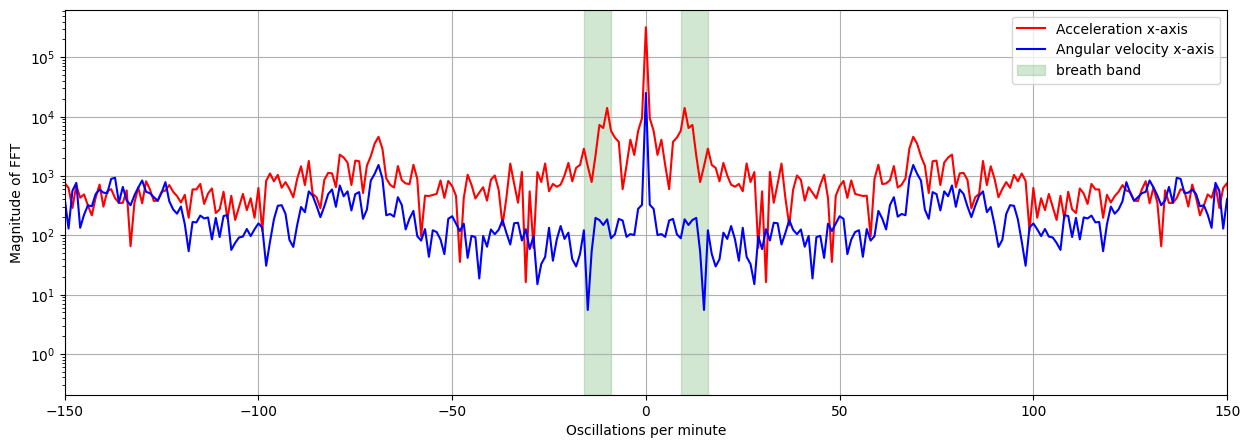

In [19]:
ts = 1/frequency

freq = fftpack.fftfreq(len(acc_x), ts)
freq_buckup = 60*freq

argmax_f = np.argmax(freq)
argmin_f = np.argmin(freq)
arglast_f = len(freq)-1
argfirst_f = 0


freq= np.sort(freq)

freq = 60*freq


absfft_acc = np.abs(fftpack.fft(acc_x))
absfft_acc_buckup = np.abs(fftpack.fft(acc_x))
absfft_acc = np.concatenate((absfft_acc[argmin_f:arglast_f+1], absfft_acc[argfirst_f:argmax_f+1]))


absfft_vel = np.abs(fftpack.fft(vel_x))
absfft_vel_buckup = np.abs(fftpack.fft(vel_x))
absfft_vel = np.concatenate((absfft_vel[argmin_f:arglast_f+1], absfft_vel[argfirst_f:argmax_f+1]))


fig, ax = plt.subplots(figsize = (15, 5))

plt.plot(freq, absfft_acc, color='red', label='Acceleration x-axis')
plt.plot(freq, absfft_vel, color='blue', label='Angular velocity x-axis')

plt.yscale('log')
plt.grid()
plt.xlabel('Oscillations per minute')
plt.ylabel('Magnitude of FFT')
plt.legend()
plt.xlim(-150,150)

min_freq = 9
max_freq = 16
plt.axvspan(min_freq, max_freq, color='forestgreen', alpha = 0.2, label='breath band')
plt.axvspan(-max_freq, -min_freq, color='forestgreen', alpha = 0.2)
plt.legend()

plt.show()


The range of frquencies given as output by the method *fftfreq* of the Scipy library is very wide, and this is because of the large number of samples we have (in the graph above, the frequency axis goes from -150 to 150 oscillations per minute in order to have a clearer representation of the spectrum). <br>
However, the band we are interested in is limited by the possible respiratory rates that healty human beings can have: we considered a minimum frequency of 9 breaths per minute and a maximum frequency of 16 breaths per minute. The region of interest is highlited with a green stripe in the previous graph.

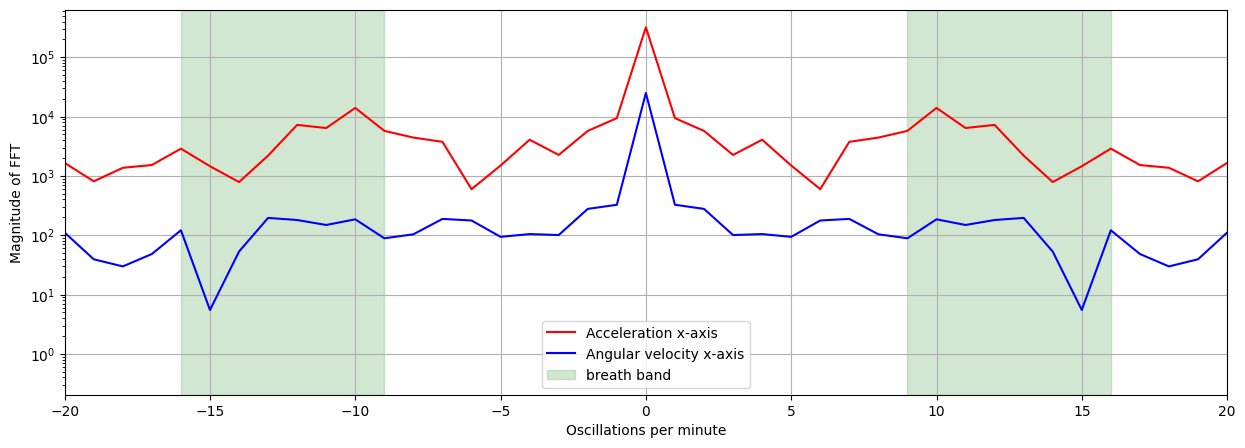

In [20]:
fig, ax = plt.subplots(figsize = (15, 5))
plt.plot(freq, absfft_acc, color='red', label='Acceleration x-axis')
plt.plot(freq, absfft_vel, color='blue',label='Angular velocity x-axis')
plt.yscale('log')
plt.grid()
plt.xlabel('Oscillations per minute')
plt.ylabel('Magnitude of FFT')
plt.xlim(-20,20)

plt.axvspan(min_freq, max_freq, color='forestgreen', alpha = 0.2, label='breath band')
plt.axvspan(-max_freq, -min_freq, color='forestgreen', alpha = 0.2)
plt.legend()

plt.show()

From the plot above, we can see that the global maxima in the region of interest provided by the two instruments along x-axis are different. In particular, there is a relatively high peak around 10 breaths per minute in the accelerometer while the peak for the angular velocity is around 13 breaths per minute. 
<br>
As indicated in literature [2], in this situation the acceleration measurement is considered more relevant.

## 3. Filter

Now we have to filter the data in order to discard all those frequency components outside the band of our interest. <br>
We implement a simple pass-band filter by setting to zero the values of the Fourier Transform which correspond to harmonics outside the band.
<br><br>
After filtering, a inverse transform is performed in order to see the clean signal in the time domain.

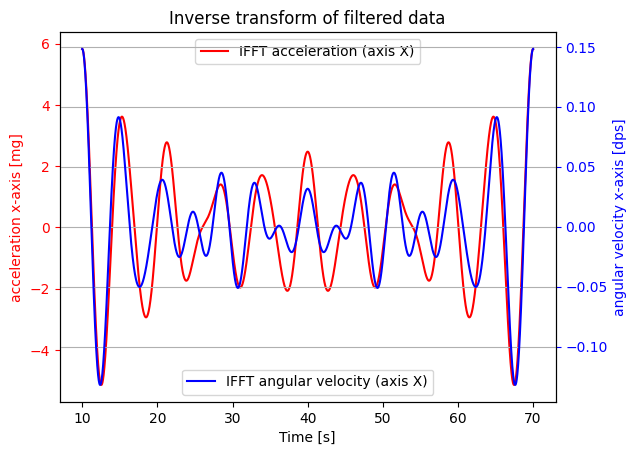

In [21]:
filtered_acc = absfft_acc_buckup
filtered_vel = absfft_vel_buckup

filtered_acc[(np.abs(freq_buckup) < min_freq) | (np.abs(freq_buckup) > max_freq)] = 0

filtered_vel[(np.abs(freq_buckup) < min_freq) | (np.abs(freq_buckup) > max_freq)] = 0

inv_acc = np.real(fftpack.ifft(filtered_acc))
inv_vel = np.real(fftpack.ifft(filtered_vel))

plt.plot(times, inv_acc, color='red', label='IFFT acceleration (axis X)')
plt.ylabel('acceleration x-axis [mg]', color = 'red')
plt.xlabel('Time [s]')
plt.legend(loc = 'upper center', ncol = 4)
plt.gca().tick_params(axis='y', colors='red')

plt.twinx()
plt.ylabel('angular velocity x-axis [dps]', color = 'blue')
plt.plot(times, inv_vel,color='blue', label='IFFT angular velocity (axis X)')
plt.gca().tick_params(axis='y', colors='blue')
plt.legend()
plt.title('Inverse transform of filtered data')
plt.grid()
plt.show()

A different choice, more feasible in the reality is to use a digital filter, which uses a linear combination of input and output samples to filter out the desired frequencies.<br>
Since it does not make direct use of the Fourier Transform its performances are worse than the ones of the previous solution, indeed the oscillations are less regular than  before. This particular digital passband filter is created placing in cascade a lowpass and a highpass filter, each of them is of order 2.

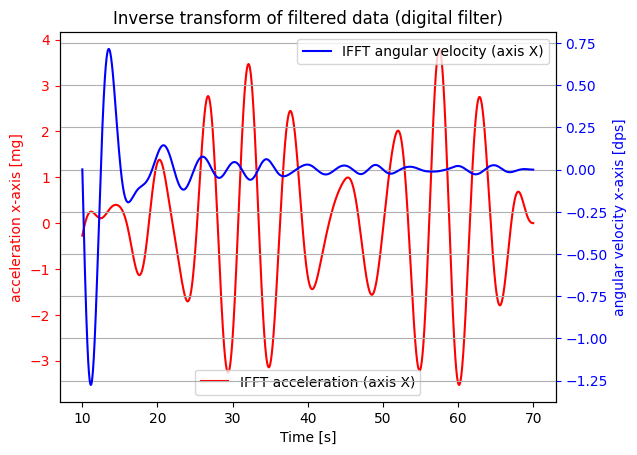

In [22]:
from scipy.signal import butter, filtfilt

fs = 200  # Hz

lowcut = 0.15  # Hz
highcut = 0.27  # Hz

normalized_lowcut = lowcut / (fs / 2)
normalized_highcut = highcut / (fs / 2)

order = 2


b, a = butter(order, [normalized_lowcut, normalized_highcut], btype='bandpass')


filt_digital_acc = filtfilt(b, a, acc_x)
filt_digital_vel = filtfilt(b, a, vel_x)

plt.plot(times, filt_digital_acc, color='red', label='IFFT acceleration (axis X)')
plt.xlabel('Time [s]')
plt.ylabel('acceleration x-axis [mg]', color = 'red')
plt.gca().tick_params(axis='y', colors='red')
plt.legend(loc='lower center')

plt.twinx()
plt.ylabel('angular velocity x-axis [dps]', color = 'blue')
plt.plot(times, filt_digital_vel, color='blue',label='IFFT angular velocity (axis X)')
plt.grid()
plt.gca().tick_params(axis='y', colors='blue')

plt.title('Inverse transform of filtered data (digital filter)')
plt.legend()
plt.show()


An estimate of the respiratory rate can be obtained by looking at the main harmonic within the band. We obtain simalar but different results from the accelerometer and the gyroscope, for the reason explained before, the data given by the accelerometer will be considered.

In [23]:
rr_acc_x = np.argmax(filtered_acc)
rr_vel_x = np.argmax(filtered_vel)
print('Resipiratory rate looking at acceleration along axis x: ', rr_acc_x, ' breaths per minute')
print('Respiratory rate looking at angular velocity along axis x: ', rr_vel_x, ' breaths per minute')

Resipiratory rate looking at acceleration along axis x:  10  breaths per minute
Respiratory rate looking at angular velocity along axis x:  13  breaths per minute


Looking at the filtered inverse transform we can count 10 oscillations; this number is congruent with the respiratory rate we have just found since our time window is 60 seconds long.

The next lines of code aim to measure the time duration of each breath and to provide a statistical analysis. However, the available data are too few and we can't do a significant analysis.

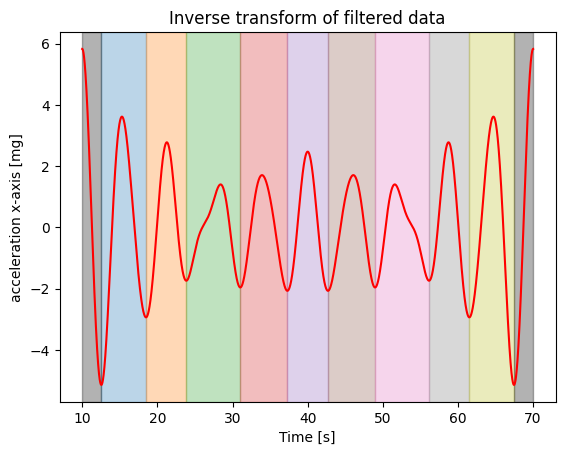

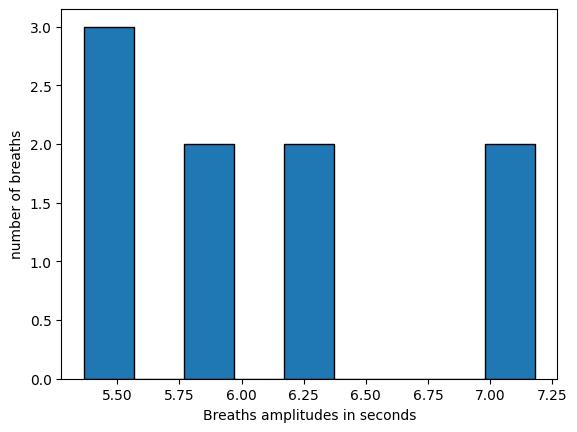

In [24]:
minima, _ = find_peaks(-inv_acc)
minima_t = times[minima]

plt.plot(times, inv_acc, color='red', label='IFFT acceleration (axis X)')


cmap = plt.get_cmap('tab20')
colors = [cmap(i / len(minima)) for i in range(len(minima))]


periods = []

for i in range(len(minima_t)-1):
    plt.axvspan(minima_t[i], minima_t[i+1], alpha = 0.3, color=colors[i]) 
    periods.append(minima_t[i+1]-minima_t[i])
    
plt.axvspan(10, minima_t[0], color='black', alpha=0.3)
plt.axvspan(minima_t[i+1], 70, color='black', alpha=0.3)
plt.xlabel('Time [s]')
plt.ylabel('acceleration x-axis [mg]')
plt.title('Inverse transform of filtered data')
plt.show()
    
periods = np.array(periods)

plt.hist(periods, bins = 9, edgecolor='black', density = False)
plt.xlabel('Breaths amplitudes in seconds')
plt.ylabel('number of breaths')
plt.show()

Below are the functions that are used for fitting.

/var/folders/gk/x5js395j2q5g485hthdhw0l80000gn/T/ipykernel_2042/2574291805.py:8: RuntimeWarning: invalid value encountered in power
  return (b / a) * (x / a)**(b - 1) / (1 + (x / a)**b)**2


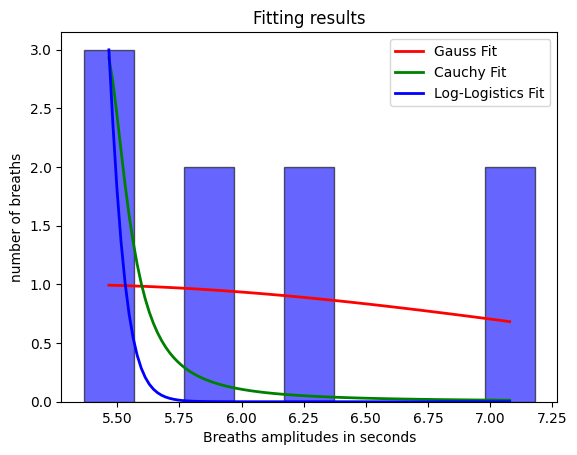

In [25]:
def Gauss(x, mu, sigma):
    return np.exp(-(x - mu)**2 / (2 * sigma**2))

def Cauchy(x, t, s):
    return 1 / (s * np.pi * (1 + ((x - t) / s)**2))

def Log_Logistics(x, a, b):
    return (b / a) * (x / a)**(b - 1) / (1 + (x / a)**b)**2


hist, bin_edges = np.histogram(periods, bins=9)


bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2


initial_mu = np.mean(periods)
initial_sigma = np.std(periods)


params_Gauss, covariance_Gauss = curve_fit(Gauss, bin_centers, hist, p0=[initial_mu, initial_sigma])
params_Cauchy, covariance_Cauchy = curve_fit(Cauchy, bin_centers, hist, p0=[initial_mu, initial_sigma])
params_Log_Logistics, covariance_Log_Logistics = curve_fit(Log_Logistics, bin_centers, hist, p0=[initial_mu, initial_sigma])


plt.hist(periods, bins=9, edgecolor='black', density=False, alpha=0.6, color='b')

x = np.linspace(np.min(bin_centers), np.max(bin_centers), 100)
plt.plot(x, Gauss(x, *params_Gauss), 'r', linewidth=2, label='Gauss Fit')
plt.plot(x, Cauchy(x, *params_Cauchy), 'g', linewidth=2, label='Cauchy Fit')
plt.plot(x, Log_Logistics(x, *params_Log_Logistics), 'b', linewidth=2, label='Log-Logistics Fit')

plt.title('Fitting results')
plt.xlabel('Breaths amplitudes in seconds')
plt.ylabel('number of breaths')
plt.legend()

plt.show()


We can see that the available data are too few and none of the proposed curves can fit properly the histogram.

## Second Dataset
The second dataset is taken placing the sensors on a bed stave, under the mattress at the level of the chest, so the technique is BCG.
<br>
The first steps are the same as before.

### 1.1 Load file and select the columns

In [26]:
file = pd.read_csv('1_Stave_supine_static.txt', delimiter='\t')
df = pd.DataFrame(file)

#show the dataframe
display(df)

#description of data
df.describe()

,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
0,5,100,1555487493,490.379,308.172,863.028,-40.73171,30.975610,45.853660,-642,-90,-83,0.182482,0.375561,0.139683,0.897855
1,5,100,1555487493,32.513,230.153,1015.406,23.90244,25.609760,40.731710,-177,-185,-321,0.910500,0.099033,0.037385,0.399731
2,5,100,1555487493,36.539,256.200,1012.051,-21.46342,3.780488,11.219510,-179,-185,-325,0.881061,0.112613,0.042390,0.457442
3,5,100,1555487493,65.331,241.194,1013.454,-30.24390,11.219510,6.341464,-180,-185,-325,0.877629,0.112827,0.042695,0.463912
4,5,100,1555487493,19.337,250.649,1004.121,-35.73171,12.926830,0.975610,-178,-182,-328,0.876462,0.111820,0.042726,0.466353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9165,5,100,1555487805,75.274,-682.590,664.778,34.14634,31.585370,-59.146340,-142,257,-480,0.153829,-0.093692,0.324564,-0.928556
9166,5,100,1555487805,131.760,-664.717,704.428,35.12195,21.097560,-68.292690,-138,255,-482,0.148201,-0.093112,0.321390,-0.930631
9167,5,100,1555487805,168.665,-679.479,751.581,36.70732,17.682930,-76.097560,-142,254,-479,0.142147,-0.093326,0.317850,-0.932768
9168,5,100,1555487805,204.472,-709.491,826.794,40.12195,18.170730,-87.195120,-139,253,-479,0.135352,-0.093844,0.314005,-0.935026


,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
count,9170.0,9170.0,9.170000e+03,9170.000000,9170.000000,9170.000000,9170.000000,9170.000000,9170.000000,9170.000000,9170.000000,9170.000000,9170.000000,9170.000000,9170.000000,9170.000000
mean,5.0,100.0,1.555488e+09,25.152432,-6.889359,-786.807180,-3.862954,8.035535,-4.567811,-12.581352,100.906652,478.641549,0.068807,0.586509,0.598754,0.038196
std,0.0,0.0,2.797422e+01,172.065725,182.502701,485.641233,81.028227,88.647127,53.009184,93.515042,68.825906,235.872181,0.198851,0.360566,0.308888,0.162410
min,5.0,100.0,1.555487e+09,-3626.000000,-2989.000000,-3626.000000,-1864.024000,-1594.146000,-1264.024000,-742.000000,-332.000000,-498.000000,0.001983,-0.942686,-0.727622,-0.938475
25%,5.0,100.0,1.555488e+09,38.064000,18.117000,-929.335000,-2.682927,1.585366,0.243902,2.000000,102.000000,547.000000,0.006469,0.704428,0.706321,0.027772
50%,5.0,100.0,1.555488e+09,43.371000,21.167000,-922.991000,-2.560976,1.707317,0.365854,3.000000,103.000000,549.000000,0.007619,0.705557,0.707572,0.028199
75%,5.0,100.0,1.555488e+09,47.153000,23.851000,-913.658000,-2.439024,1.829268,0.487805,4.000000,104.000000,550.000000,0.009252,0.706626,0.708518,0.028596
max,5.0,100.0,1.555488e+09,1960.000000,2793.000000,5733.000000,3614.878000,3932.195000,519.878100,326.000000,633.000000,570.000000,0.997440,0.945555,0.748161,0.897855


In [27]:
frequency = df['Log Freq'].unique()[0] 
count = df.shape[0]

time_arr = np.arange(0,(count/frequency),(1/frequency))

In [28]:
columns_drop = [
    'Timestamp',
    'qw',
    'qi',
    'qk',
    'qj',
    'Log Freq',
    'Log Mode',
    'MagnX',
    'MagnY',
    'MagnZ'
]
partial_data = df.drop(columns_drop,axis=1)
partial_data.insert(0,'Time',time_arr)
display(partial_data)

,Time,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
0,0.00,490.379,308.172,863.028,-40.73171,30.975610,45.853660
1,0.01,32.513,230.153,1015.406,23.90244,25.609760,40.731710
2,0.02,36.539,256.200,1012.051,-21.46342,3.780488,11.219510
3,0.03,65.331,241.194,1013.454,-30.24390,11.219510,6.341464
4,0.04,19.337,250.649,1004.121,-35.73171,12.926830,0.975610
...,...,...,...,...,...,...,...
9165,91.65,75.274,-682.590,664.778,34.14634,31.585370,-59.146340
9166,91.66,131.760,-664.717,704.428,35.12195,21.097560,-68.292690
9167,91.67,168.665,-679.479,751.581,36.70732,17.682930,-76.097560
9168,91.68,204.472,-709.491,826.794,40.12195,18.170730,-87.195120


The offsets of the new data are now taken from the file "config_5.txt".

In [29]:
offsets = [3.602701,-20.96658,54.97186]

partial_data['AccX'] -= offsets[0]
partial_data['AccY'] -= offsets[1]
partial_data['AccZ'] -= offsets[2]

display(partial_data)
partial_data.describe()

,Time,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
0,0.00,486.776299,329.13858,808.05614,-40.73171,30.975610,45.853660
1,0.01,28.910299,251.11958,960.43414,23.90244,25.609760,40.731710
2,0.02,32.936299,277.16658,957.07914,-21.46342,3.780488,11.219510
3,0.03,61.728299,262.16058,958.48214,-30.24390,11.219510,6.341464
4,0.04,15.734299,271.61558,949.14914,-35.73171,12.926830,0.975610
...,...,...,...,...,...,...,...
9165,91.65,71.671299,-661.62342,609.80614,34.14634,31.585370,-59.146340
9166,91.66,128.157299,-643.75042,649.45614,35.12195,21.097560,-68.292690
9167,91.67,165.062299,-658.51242,696.60914,36.70732,17.682930,-76.097560
9168,91.68,200.869299,-688.52442,771.82214,40.12195,18.170730,-87.195120


,Time,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
count,9170.000000,9170.000000,9170.000000,9170.000000,9170.000000,9170.000000,9170.000000
mean,45.845000,21.549731,14.077221,-841.779040,-3.862954,8.035535,-4.567811
std,26.472953,172.065725,182.502701,485.641233,81.028227,88.647127,53.009184
min,0.000000,-3629.602701,-2968.033420,-3680.971860,-1864.024000,-1594.146000,-1264.024000
25%,22.922500,34.461299,39.083580,-984.306860,-2.682927,1.585366,0.243902
50%,45.845000,39.768299,42.133580,-977.962860,-2.560976,1.707317,0.365854
75%,68.767500,43.550299,44.817580,-968.629860,-2.439024,1.829268,0.487805
max,91.690000,1956.397299,2813.966580,5678.028140,3614.878000,3932.195000,519.878100


### 1.2 Plot selected data and choose a proper time window

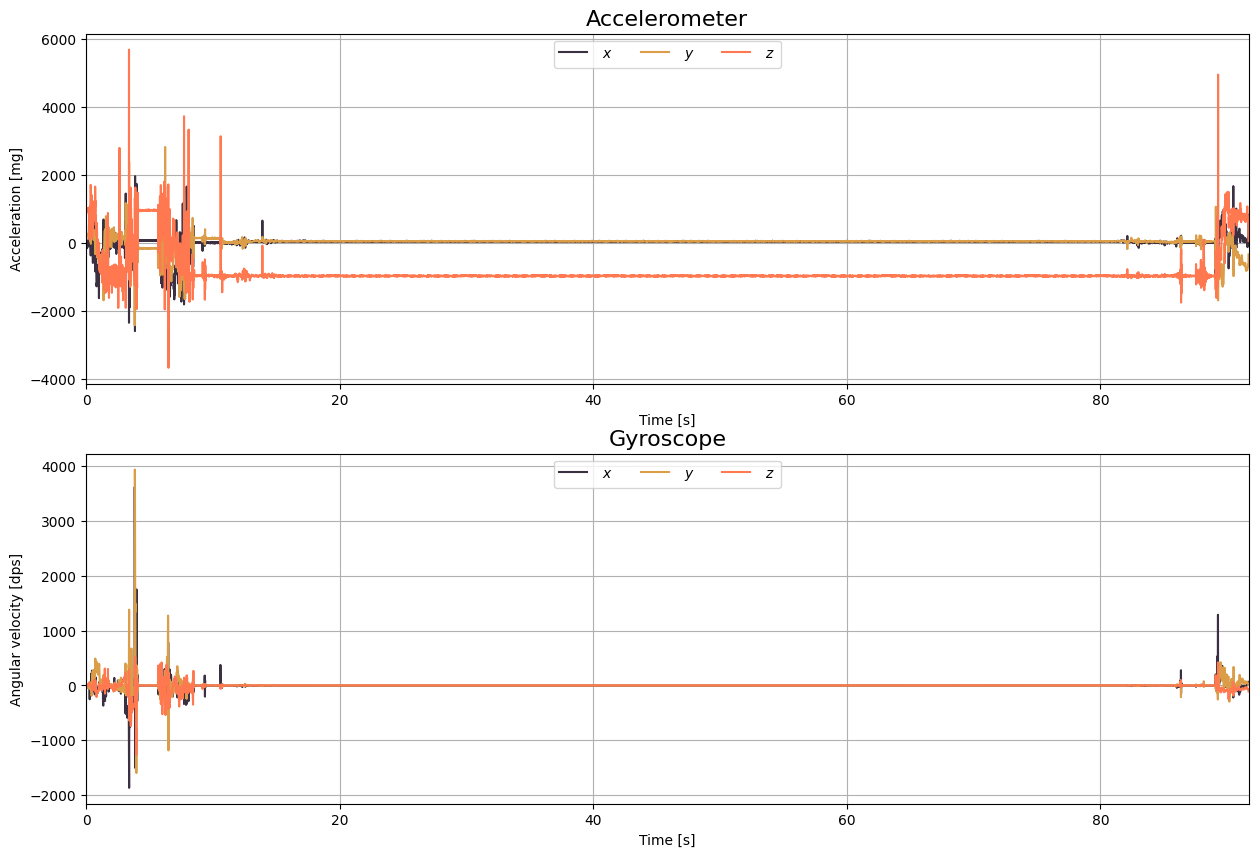

In [30]:
fig1, ax1 = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 10))

ax1[0].plot(partial_data['Time'], partial_data['AccX'], '-', label=' $x$ ', color = color1)
ax1[0].plot(partial_data['Time'], partial_data['AccY'], '-', label=' $y$ ', color = color2)
ax1[0].plot(partial_data['Time'], partial_data['AccZ'], '-', label=' $z$ ', color = color3)
ax1[0].set_xlim(0, partial_data['Time'].max())
ax1[0].set_xlabel('Time [s]')
ax1[0].set_ylabel('Acceleration [mg]')
ax1[0].legend(loc='upper center', ncol = 3)
ax1[0].set_title('Accelerometer', fontsize=16)
ax1[0].grid()




ax1[1].plot(partial_data['Time'], partial_data['GyroX'], '-', label = ' $x$ ', color = color1)
ax1[1].plot(partial_data['Time'], partial_data['GyroY'], '-', label = ' $y$ ', color = color2)
ax1[1].plot(partial_data['Time'], partial_data['GyroZ'], '-', label = ' $z$ ', color = color3)
ax1[1].set_xlim(0, partial_data['Time'].max())
ax1[1].set_title('Gyroscope', fontsize = 16)
ax1[1].set_xlabel('Time [s]')
ax1[1].set_ylabel('Angular velocity [dps]')
ax1[1].legend(loc = 'upper center', ncol = 3)
ax1[1].grid()

As did before, we drop the portion of the signals where oscillations are meaningless for our purpose.

In [31]:
center_idx = int(partial_data.shape[0]/2)
down_idx = 1600
up_idx = 8000
print(f'The percentage of data to keep is {(up_idx-down_idx)/partial_data.shape[0]*100:.2f}% ' )

down_limit = (partial_data['Time'])[down_idx]
up_limit = (partial_data['Time'])[up_idx]

The percentage of data to keep is 69.79% 


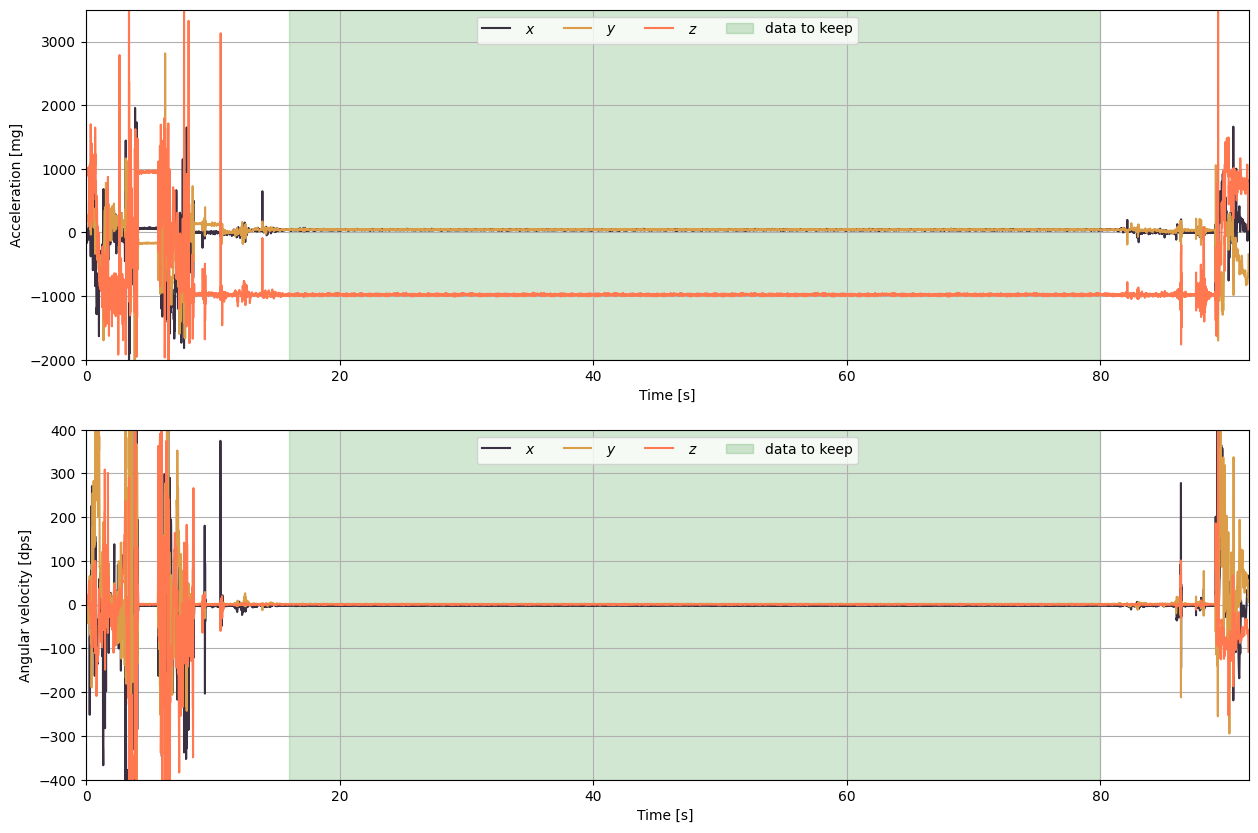

In [32]:
fig3, ax3 = plt.subplots(nrows = 2, figsize = (15, 10))

ax3[0].plot(partial_data['Time'],partial_data['AccX'], '-', label = ' $x$ ', color = '#3a3042')
ax3[0].plot(partial_data['Time'],partial_data['AccY'], '-', label = ' $y$ ', color = '#db9d47')
ax3[0].plot(partial_data['Time'],partial_data['AccZ'], '-', label = ' $z$ ', color = '#ff784f')
ax3[0].fill_betweenx(y = [-2000, 3500], x1 = down_limit, x2 = up_limit,
                     color = 'forestgreen', alpha = 0.2, label = 'data to keep')
ax3[0].set_xlim(min(partial_data['Time']), max(partial_data['Time']))
ax3[0].set_ylim(-2000, 3500)
ax3[0].set_xlabel('Time [s]')
ax3[0].set_ylabel('Acceleration [mg]')
ax3[0].legend(loc = 'upper center', ncol = 4)
ax3[0].grid()

ax3[1].plot(partial_data['Time'], partial_data['GyroX'], '-' , label = ' $x$ ' , color='#3a3042' )
ax3[1].plot(partial_data['Time'], partial_data['GyroY'], '-' , label = ' $y$ ' , color='#db9d47' )
ax3[1].plot(partial_data['Time'], partial_data['GyroZ'], '-' , label = ' $z$ ' , color='#ff784f' )
ax3[1].fill_betweenx(y = [-400, 400], x1 = down_limit, x2 = up_limit,
                     color = 'forestgreen', alpha = 0.2, label = 'data to keep')
ax3[1].set_xlim(min(partial_data['Time']), max(partial_data['Time']))
ax3[1].set_ylim(-400, 400)
ax3[1].set_xlabel('Time [s] ')
ax3[1].set_ylabel('Angular velocity [dps]')
ax3[1].legend(loc = 'upper center', ncol = 4)
ax3[1].grid()

In [33]:
final_data = partial_data.copy()
final_data = final_data[final_data['Time'] >= down_limit]
final_data = final_data[final_data['Time'] <= up_limit]
final_data.set_index(np.arange(0,len(final_data)), inplace=True)
display(final_data)

times = np.array(final_data['Time'])

,Time,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
0,16.00,42.452299,46.15958,-990.46786,-2.317073,1.341463,0.365854
1,16.01,40.500299,46.70858,-978.02386,-2.804878,1.463415,0.365854
2,16.02,43.428299,46.15958,-979.12186,-2.804878,1.463415,0.487805
3,16.03,38.487299,44.39058,-979.73186,-2.804878,1.707317,0.487805
4,16.04,37.633299,46.40358,-959.78486,-2.682927,1.463415,0.121951
...,...,...,...,...,...,...,...
6396,79.96,43.123299,43.96358,-970.33786,-2.439024,1.585366,0.243902
6397,79.97,46.539299,42.80458,-986.31986,-2.682927,1.585366,0.609756
6398,79.98,38.853299,42.86558,-978.57286,-2.439024,1.463415,0.487805
6399,79.99,38.060299,40.79158,-961.12686,-2.682927,1.585366,0.121951


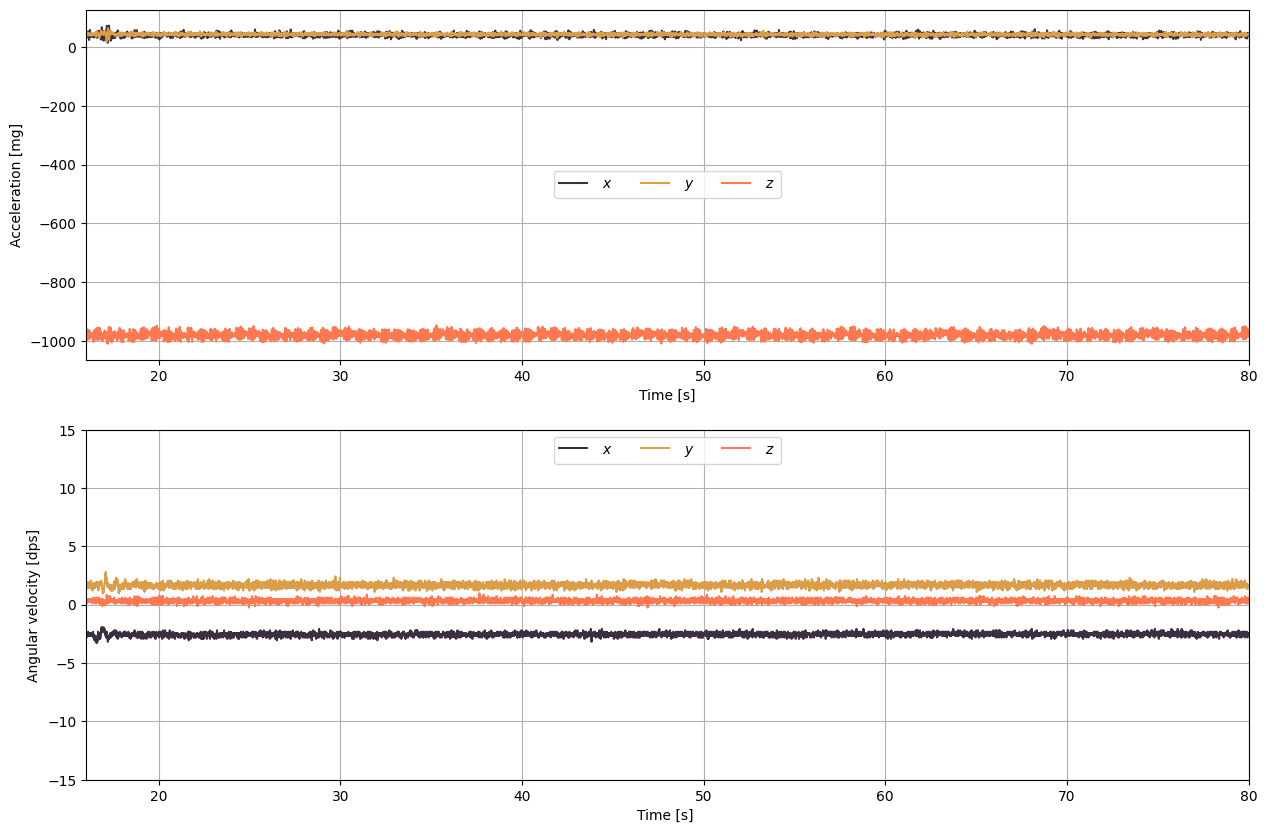

In [34]:
fig3, ax3 = plt.subplots(nrows = 2, figsize = (15, 10))

ax3[0].plot(final_data['Time'],final_data['AccX'], '-', label = ' $x$ ', color = '#3a3042')
ax3[0].plot(final_data['Time'],final_data['AccY'], '-', label = ' $y$ ', color = '#db9d47')
ax3[0].plot(final_data['Time'],final_data['AccZ'], '-', label = ' $z$ ', color = '#ff784f')
ax3[0].set_xlim(min(final_data['Time']), max(final_data['Time']))



ax3[0].set_xlabel('Time [s]')
ax3[0].set_ylabel('Acceleration [mg]')
ax3[0].legend(loc = 'center', ncol = 4)
ax3[0].grid()

ax3[1].plot(final_data['Time'], final_data['GyroX'], '-' , label = ' $x$ ' , color='#3a3042' )
ax3[1].plot(final_data['Time'], final_data['GyroY'], '-' , label = ' $y$ ' , color='#db9d47' )
ax3[1].plot(final_data['Time'], final_data['GyroZ'], '-' , label = ' $z$ ' , color='#ff784f' )

ax3[1].set_xlim(min(final_data['Time']), max(final_data['Time']))
ax3[1].set_ylim(-15, 15)
ax3[1].set_xlabel('Time [s] ')
ax3[1].set_ylabel('Angular velocity [dps]')
ax3[1].legend(loc = 'upper center', ncol = 4)
ax3[1].grid()

### 1.3 Consider particular axis or combination of them

As explained before, we perform PCA on the second dataset, in order too see how the information is divided on the axes.


In [35]:
data_acc = final_data[['AccX','AccY','AccZ']]

data_gyro = final_data[['GyroX','GyroY','GyroZ']]

1.3.1 PCA on accelerometer data

In [36]:
#PCA with eigen decomposition
acc_pca = pca_calc(data_acc)
print('PCA decomposition for accelerometer')
xyz = ['x','y','z']
for i,value in zip(xyz,np.real_if_close(acc_pca)):
    print(f"axis {i}: {value:.2f}%")

PCA decomposition for accelerometer
axis x: 18.40%
axis y: 7.60%
axis z: 74.00%


1.3.2 PCA on gyroscope data

In [37]:
gyro_pca = pca_calc(data_gyro)
print('PCA decomposition for gyroscope')
xyz = ['x','y','z']
for i,value in zip(xyz,np.real_if_close(gyro_pca)):
    print(f"axis {i}: {value:.2f}%")

PCA decomposition for gyroscope
axis x: 43.38%
axis y: 29.31%
axis z: 27.31%


In this case we can see that the information of the accelerometer is mainly contained on the z axis, but at the same time information of the gyroscope is almost homogeneusly distributed on all the axes. 
Therefore, we can not neglect some axes but we have to consider all of them (both in accelerometer and gyroscope) in order to obtain significan results.

We calculate the norm of the vector $\vec{v}$ for each instrument as $\| \vec{v} \| = \sqrt{x^2 + y^2 + z^2} $.

To do that, we use the function 'calculate_norm()' defined before.

In [38]:
acc_norm = calculate_norm(data_acc)
vel_norm = calculate_norm(data_gyro)

We can now compute and plot the Fast Fourier Transform. 

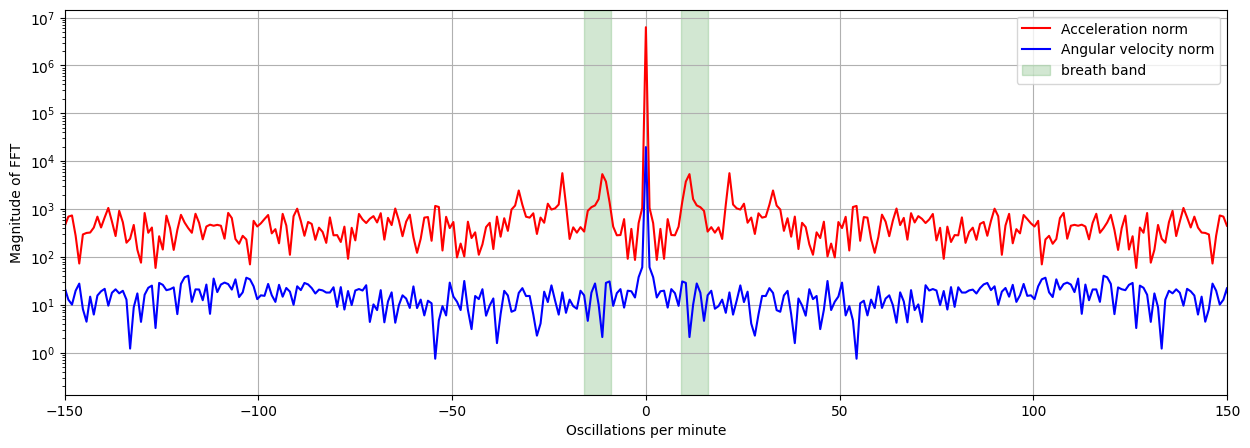

In [39]:
ts = 1/frequency

freq = fftpack.fftfreq(len(acc_norm), ts)
freq_buckup = 60*freq

argmax_f = np.argmax(freq)
argmin_f = np.argmin(freq)
arglast_f = len(freq)-1
argfirst_f = 0


freq = np.sort(freq)

freq = 60*freq

absfft_acc = np.abs(fftpack.fft(acc_norm))
absfft_acc_buckup = np.abs(fftpack.fft(acc_norm))
absfft_acc = np.concatenate((absfft_acc[argmin_f:arglast_f+1], absfft_acc[argfirst_f:argmax_f+1]))

#parte cambiata
absfft_vel = np.abs(fftpack.fft(vel_norm))
absfft_vel_buckup = np.abs(fftpack.fft(vel_norm))
absfft_vel = np.concatenate((absfft_vel[argmin_f:arglast_f+1], absfft_vel[argfirst_f:argmax_f+1]))
#
fig, ax = plt.subplots(figsize = (15, 5))

plt.plot(freq, absfft_acc, color='red', label='Acceleration norm')
plt.plot(freq, absfft_vel, color='blue', label='Angular velocity norm')


plt.yscale('log')
plt.grid()
plt.xlabel('Oscillations per minute')
plt.ylabel('Magnitude of FFT')

plt.xlim(-150,150)

min_freq = 9
max_freq = 16
plt.axvspan(min_freq, max_freq, color='forestgreen', alpha = 0.2, label = 'breath band')
plt.axvspan(-max_freq, -min_freq, color='forestgreen', alpha = 0.2)
plt.legend()

plt.show()

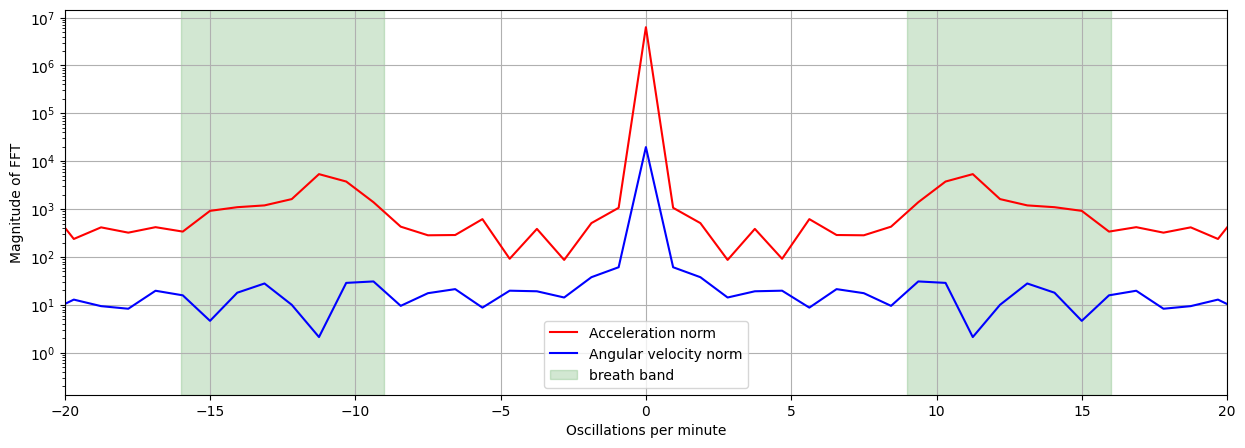

In [40]:
fig, ax = plt.subplots(figsize = (15, 5))
plt.plot(freq, absfft_acc, color='red', label='Acceleration norm')
plt.plot(freq, absfft_vel, color='blue', label='Angular velocity norm')
plt.yscale('log')
plt.grid()
plt.xlabel('Oscillations per minute')
plt.ylabel('Magnitude of FFT')
plt.legend()
plt.xlim(-20,20)

plt.axvspan(min_freq, max_freq, color='forestgreen', alpha = 0.2)
plt.axvspan(-max_freq, -min_freq, color='forestgreen', alpha = 0.2, label='breath band')
plt.legend()
plt.show()

We implement the pass-band filter and we perform the inverse transform in order to see the clean signal in the time domain.

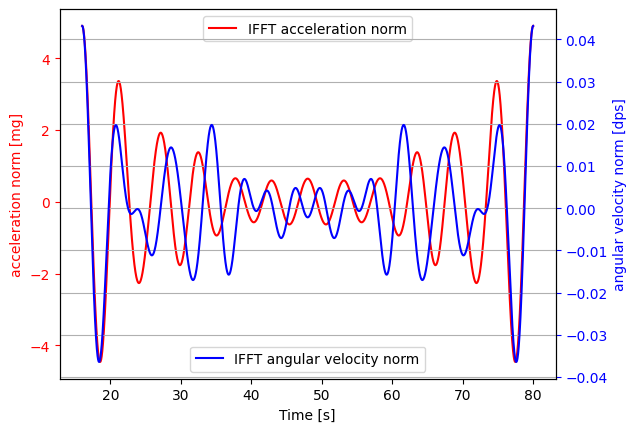

In [41]:
filtered_acc = absfft_acc_buckup

filtered_acc[(np.abs(freq_buckup) < min_freq) | (np.abs(freq_buckup) > max_freq)] = 0
filtered_vel = absfft_vel_buckup

filtered_vel[(np.abs(freq_buckup) < min_freq) | (np.abs(freq_buckup) > max_freq)] = 0

inv_acc = np.real(fftpack.ifft(filtered_acc))
inv_vel = np.real(fftpack.ifft(filtered_vel))

plt.plot(times, inv_acc, color='red', label='IFFT acceleration norm')
plt.xlabel('Time [s]')
plt.ylabel('acceleration norm [mg]', color = 'red')
plt.gca().tick_params(axis='y', colors='red')
plt.legend(loc='upper center')

plt.twinx()
plt.gca().tick_params(axis='y', colors='blue')
plt.plot(times,inv_vel, color='blue', label='IFFT angular velocity norm')
plt.ylabel('angular velocity norm [dps]', color = 'blue')

plt.legend()
plt.grid()
plt.show()

In [42]:
rr_acc_norm = np.argmax(filtered_acc)
print('Resipiratory rate looking at acceleration norm: ', rr_acc_norm, ' breaths per minute')
rr_vel_norm = np.argmax(filtered_vel)
print('Resipiratory rate looking at angular velocity norm: ', rr_vel_norm, ' breaths per minute')


Resipiratory rate looking at acceleration norm:  12  breaths per minute
Resipiratory rate looking at angular velocity norm:  10  breaths per minute


Even for this dataset we obtain simalar but differet results from the accelerometer and the gyroscope. As indicated in literature [2], also in this situation the acceleration measurement is considered more relevant.

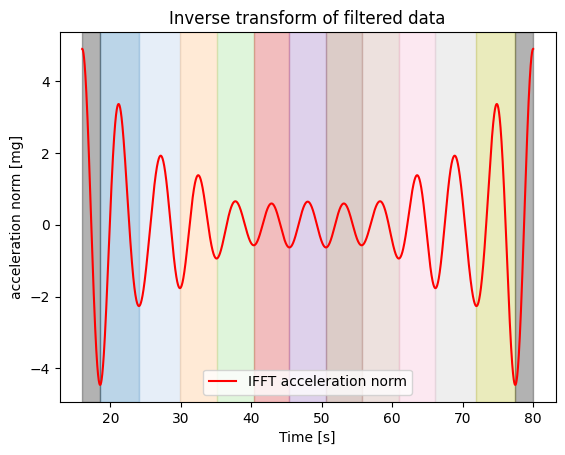

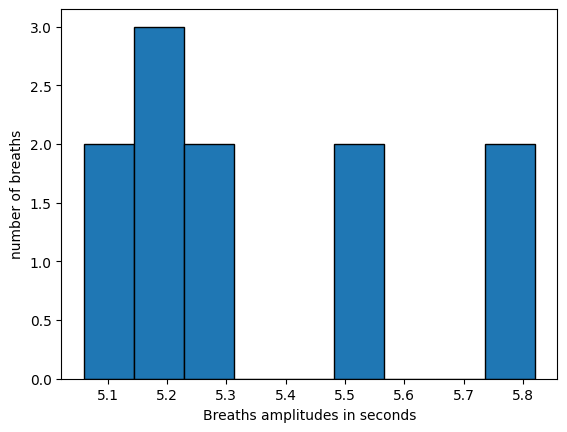

In [43]:
minima, _ = find_peaks(-inv_acc)
minima_t = times[minima]

plt.plot(times, inv_acc, color='red', label='IFFT acceleration norm')
plt.xlabel('Time [s]')
plt.legend()
cmap = plt.get_cmap('tab20')
colors = [cmap(i / len(minima)) for i in range(len(minima))]

periods = []

for i in range(len(minima_t)-1):
    plt.axvspan(minima_t[i], minima_t[i+1], alpha = 0.3, color=colors[i]) 
    periods.append(minima_t[i+1]-minima_t[i])

plt.axvspan(16, minima_t[0], color='black', alpha=0.3)
plt.axvspan(minima_t[i+1], 80, color='black', alpha=0.3)    
plt.ylabel('acceleration norm [mg]')
plt.title('Inverse transform of filtered data')

plt.xlabel('Time [s]')
plt.title('Inverse transform of filtered data')
plt.show()

periods = np.array(periods)
plt.hist(periods, bins = 9, edgecolor='black', density = False)


plt.xlabel('Breaths amplitudes in seconds')
plt.ylabel('number of breaths')

plt.show()

Below there are the functions that are used for fitting.

/var/folders/gk/x5js395j2q5g485hthdhw0l80000gn/T/ipykernel_2042/2574291805.py:8: RuntimeWarning: invalid value encountered in power
  return (b / a) * (x / a)**(b - 1) / (1 + (x / a)**b)**2


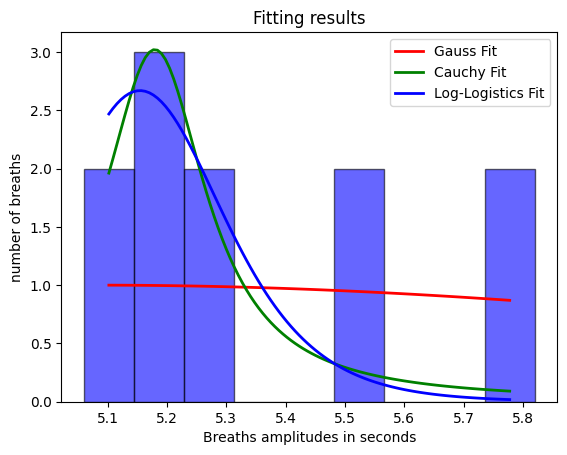

In [44]:
hist, bin_edges = np.histogram(periods, bins=9)


bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2


initial_mu = np.mean(periods)
initial_sigma = np.std(periods)


params_Gauss, covariance_Gauss = curve_fit(Gauss, bin_centers, hist, p0=[initial_mu, initial_sigma])
params_Cauchy, covariance_Cauchy = curve_fit(Cauchy, bin_centers, hist, p0=[initial_mu, initial_sigma])
params_Log_Logistics, covariance_Log_Logistics = curve_fit(Log_Logistics, bin_centers, hist, p0=[initial_mu, initial_sigma])


plt.hist(periods, bins=9, edgecolor='black', density=False, alpha=0.6, color='b')

x = np.linspace(np.min(bin_centers), np.max(bin_centers), 100)
plt.plot(x, Gauss(x, *params_Gauss), 'r', linewidth=2, label='Gauss Fit')
plt.plot(x, Cauchy(x, *params_Cauchy), 'g', linewidth=2, label='Cauchy Fit')
plt.plot(x, Log_Logistics(x, *params_Log_Logistics), 'b', linewidth=2, label='Log-Logistics Fit')

plt.title('Fitting results')
plt.xlabel('Breaths amplitudes in seconds')
plt.ylabel('number of breaths')
plt.legend()

plt.show()


Again, we can't do a significant statistical analysis because of the short acquisition time and none of the proposed curves is able to fit the data in a good way.

## Conclusions

We implemented a simplified way for the estimation of the Respiratory Rate from acceleration and angular velocity along the tree axes. 
<br><br>
The two insturments provided similar but slightly different results in the band of interest for both subjects, however in this work we always decided to consider the data of the accelerometer. This choice is motivated by the papers indicated below [2] and confirmed by the fact that the peaks of the accelerometer are relatively higher than the ones of the gyroscope in both cases.
<br><br>
The first subject has a respiratory rate of 10 bps while the second of 12 bps. These two values belongs to the lower half of the considered band (which goes from 9 to 16 bps) and this may be due to the fact that the subjcects are lying supine, so in a rest position.
<br><br>
About the statistical analysis and the related Respiratory Rate Variability, in both scenarios the amount of collected data were to few for a meaningful study so the fitting curves are never satisfactory.  


## References
* [1] Inan OT, Migeotte PF, Park KS, et al. Ballistocardiography and seismocardiography: a review of recent advances. IEEE J Biomed Health Inform. 2015;19(4):1414-1427. doi:10.1109/JBHI.2014.2361732
<br>

* [2] Romano C, Schena E, Formica D, Massaroni C. Comparison between Chest-Worn Accelerometer and Gyroscope Performance for Heart Rate and Respiratory Rate Monitoring. Biosensors (Basel). 2022;12(10):834. Published 2022 Oct 6. doi:10.3390/bios12100834
